## Speech Segmentation

### Mixing Synthesized and Whispered Glottis

In Perrotin and McLoughlin, they find that a good indicator of wether a sound should be vocalized or not (or how much each segment should be vocalized) is by using the Spectral Centre of Gravity of a Signal. Assuming a sampling frequency $F_S$ and a continuous frequency spectrum $S(f)$, it's centre of gravity is given by:

$$F_{CoG} = \frac{\int_0^{F_s/2}f |S(f)|^2 \,df}{\int_0^{F_s/2}|S(f)|^2 \,df}$$

This can be easily be applied to the discrete frequency case of the ODFT:

$$F_{CoG} = \frac{\sum_{k=0}^{N-1}f_k |X[k]|^2}{\sum_{k=0}^{N-1}|X[k]|^2}; f_k = \frac{kF_s}{N}$$

#### Speech Detection (?)

We should also detect when there is no speech occurring, so measuring the total energy of the signal is a good indicator of that, which can be taken directly from the PSD:

$$E = \sum_{k=0}^{N-1}|X[k]|^2$$


| Test Subject | Phrase | Geometric Avg Fundamental Frequency (Hz) | Used Frequency |
|--------------|-|---------------------------------------|-|
| SPF05 | Avião | 191.65 | 192 |
| SPF12 | Tiago | 165.33 | 165 |
| SPM14 | Tiago | 111.30 | 112 |
| SPM18 | Avião | 127.60 | 128 |

In [24]:
# libraries here

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, spectrogram, welch
from scipy.io import loadmat, wavfile
#from scipy.linalg import solve_toeplitz
from librosa import resample
from IPython.display import Audio
import librosa
from scipy import signal

# Data and src paths
DATA_PATH = '/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/data/'
SRC_PATH = '/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/src/'

# Audio file
TEST_SUBJECT = 'SPM18' # 'SPF05' 'SPF12' 'SPM14' 'SPM18'
TEST_PHRASE = 'Aviao' # 'Aviao' 'Tiago'
F0 = 128

#IN_AUDIO_FILE = DATA_PATH + 'vowelModels/Vowel_A.wav'
#IN_AUDIO_FILE = DATA_PATH + 'levinson.wav'
#IN_AUDIO_FILE = DATA_PATH + 'innocence.wav'
#IN_AUDIO_FILE = DATA_PATH + 'vento.wav'
#IN_AUDIO_FILE = DATA_PATH + 'aurelio.wav'
#IN_AUDIO_FILE = DATA_PATH + 'processed/SPF05_AviaoWhisperd.wav'
IN_AUDIO_FILE = DATA_PATH + 'processed/' + TEST_SUBJECT + '_' + TEST_PHRASE + 'Whisperd.wav'

#OUTPUT_FILE = DATA_PATH + 'levinsonOut.wav'
#OUTPUT_FILE = DATA_PATH + 'innocenceOut.wav'
#OUTPUT_FILE = DATA_PATH + 'ventoOut.wav'
OUTPUT_FILE = DATA_PATH + 'output.wav'
#OUTPUT_FILE = DATA_PATH + 'resultsEHLA/segmented/' + TEST_SUBJECT + '_' + TEST_PHRASE + '_3_segmentedF0.wav'

/tmp/ipykernel_4700/3012094813.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio_data = wavfile.read(IN_AUDIO_FILE)


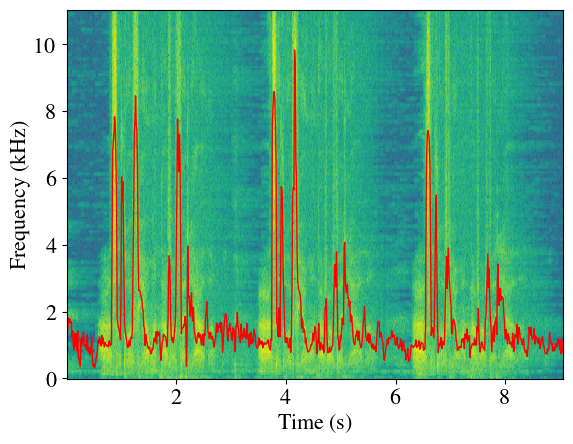

In [25]:
N = 1024; FS = 22050; N2 = N // 2

fs, audio_data = wavfile.read(IN_AUDIO_FILE)
if(len(audio_data.shape) > 1):
    audio_data = audio_data[:, 0] # remove right channel if stereo

# resample the audio data
audio_data = resample(audio_data.astype(np.float32), orig_sr=fs, target_sr=FS)
#audio_data = audio_data[:int(3.2*FS)] # trim the audio
# plot the spectrogram
frequencies, times, psd = spectrogram(audio_data, FS, nperseg=N2, noverlap=256, window='hann')

fig, ax = plt.subplots()
im = ax.pcolormesh(times, frequencies/1e3, 10 * np.log10(psd))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (kHz)')
#fig.colorbar(im, ax=ax, label='Magnitude (dB)')
#plt.title('Audio Centre of Gravity')



# calculate the spectral centre of gravity
CoG = np.sum(psd * frequencies[:, None], axis=0) / np.sum(psd, axis=0)

# plot the spectral centre of gravity on top
plt.plot(times, CoG/1e3, color='r', linewidth=1, label="Centre of Gravity")

# plot the energy contour on a secondary y axis inverted
#nergy = np.sum(psd, axis = 0)
#plt.twinx()
#plt.plot(times, energy, color='b', alpha = 0.6, linewidth=1, label="Signal Energy")
#plt.ylabel('Signal Energy')

#print(np.mean(energy)) # 25000 can be a good baseline for silence detection

#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter6/centreOfGravity.pdf', format='pdf', dpi = 300, bbox_inches='tight')

Audio(audio_data, rate=FS)

### Mapping function for the spectral centre of gravity

We can use the following sigmoid function to define the amount of voiced and unvoiced signal to mix

A sigmoid function can be thought of as a smoothed step function. It is defined for our application as such:

$$

\sigma(f) = \frac{1}{1- e^{-(f - \sqrt{F_{vuv}F_{uv}})/\lambda}}

$$

As described in the original paper, the lambda parameter is the slope of the mapping function when the frequency is the geometric mean of the $F_{vuv}$ and $F_{uv}$ parameters. A way to define this parameter is also introduced in the paper defining an auxiliary parameter $\tau$, which is the how much of the range between the two frequencies is filled by the mapping function. It is originally defined for a logarithmic frequency scale, but we can adapt it to a linear scale by defining it as:

$$
    \lambda = \frac{2}{F_{VUV}- F_{UV}} \log(\frac{1+\tau}{1-\tau})
$$

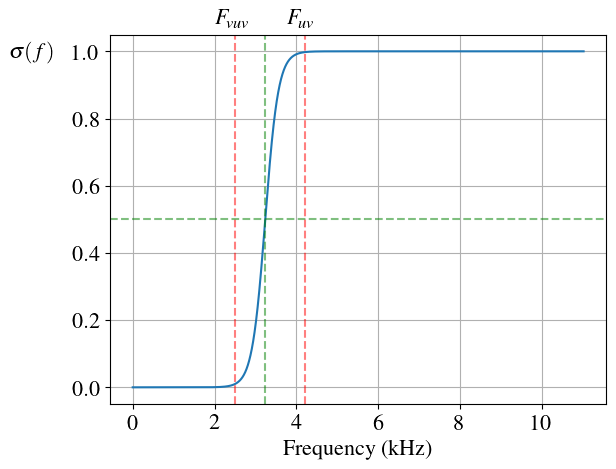

In [26]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16

FS = 22050

# Parameters
Fvuv = 2500; Fuv = 4200

f = np.linspace(0, FS/2, 10000, endpoint=False)

def m(cog, Fvuv=Fvuv, Fuv=Fuv, tau=0.99):
    lambd = 2/(Fuv - Fvuv) * np.log((1+tau)/(1-tau))
    k = (cog - np.sqrt(Fvuv*Fuv)) * lambd
    sig = 1 / (1 + np.exp(-k))
    return sig

fig, ax = plt.subplots()
ax.plot(f/1e3, m(f, Fvuv, Fuv))
ax.axvline(Fvuv/1e3, color='r', linestyle='--', alpha = 0.5)
ax.axvline(Fuv/1e3, color='r', linestyle='--', alpha = 0.5)
ax.axvline(np.sqrt(Fvuv*Fuv)/1e3, color='g', linestyle='--', alpha = 0.5)
ax.axhline(0.5, color='g', linestyle='--', alpha = 0.5)
ax.text(0.8*Fvuv/1e3, 1.08, r'$F_{vuv}$')
ax.text(0.9*Fuv/1e3, 1.08, r'$F_{uv}$')
ax.text(-3, 0.98, r'$\sigma (f)$')
ax.set_xlabel('Frequency (kHz)')
#ax.set_ylabel('Amplitude') 
ax.grid(True)
#plt.title('Vocalization Mapping Function (fully unvoiced = 1.0)')

#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter6/mapping.pdf', format='pdf', dpi = 300, bbox_inches='tight')

Text(0, 0.5, 'Voicing coefficient (voiced == 0.0)')

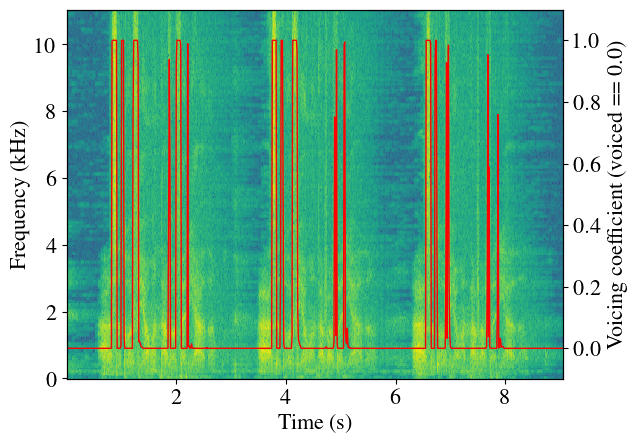

In [27]:
# Apply mapping to the CoG
mapped_CoG = m(CoG)

fig, ax = plt.subplots()

ax.pcolormesh(times, frequencies/1e3, 10 * np.log10(psd))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (kHz)')   

# plot the mapped CoG
plt.twinx()
plt.plot(times, mapped_CoG, color='r', linewidth=1, label="Mapped CoG")
plt.xlabel('Time (s)')
plt.ylim((-0.1, 1.1))
plt.ylabel('Voicing coefficient (voiced == 0.0)')
#plt.title('Mapped Centre of Gravity')
#plt.legend()
#plt.show()

#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter6/mappedCoG.pdf', format='pdf', dpi = 300, bbox_inches='tight')

### Combining both the centre of gravity and the signal energy

Although the centre of gravity is very useful for detecting the location of the most relevant formants, it is not the end-all solution that we require in this situation. As some regions are void of both unvoiced and vocalic unvoiced regions (i.e. they're silent), we should also take into account frame's energy 

#### G.729 Whispered Voice Activity Detection

The G.729 standard uses a voice activity detection algorithm that is based on the energy of the signal.

*In the Reconstruction of Normal Sounding Speech for Laryngectomy Patients through a Modified CELP coded*

Text(0.5, 1.0, 'Energy and Zero Crossing Rate (normalized)')

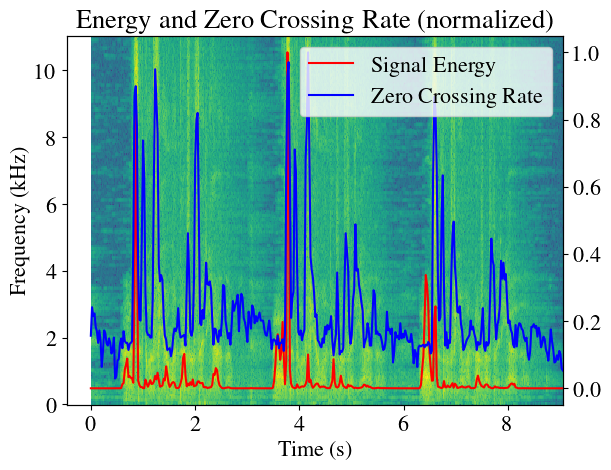

In [28]:
energy = np.array([])
zeroCrossing = np.array([])

for l in range(0, len(audio_data) - N2, N2):
    frame = audio_data[l : l + N2]
    energy = np.concatenate((energy, [np.sum(frame**2)]))
    zeroCrossingRate = np.sum(frame[:-1] * frame[1:] < 0) / len(frame)
    zeroCrossing = np.concatenate((zeroCrossing, [zeroCrossingRate]))

# normalize
zeroCrossing = zeroCrossing / max(zeroCrossing)
energy = energy / max(energy)

plt.pcolormesh(times, frequencies/1e3, 10 * np.log10(psd))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.twinx()
plt.plot(np.linspace(0, times[-1], len(energy)), energy, color='r', label='Signal Energy')
plt.plot(np.linspace(0, times[-1], len(zeroCrossing)), zeroCrossing, color='b', label='Zero Crossing Rate')
plt.legend()
plt.title('Energy and Zero Crossing Rate (normalized)')

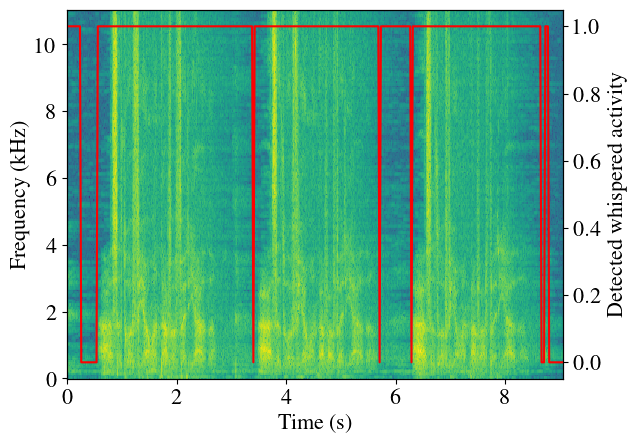

In [29]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16

# Zona de aldrabagem
audio_data_ = audio_data.copy()
#audio_data_[:int(0.3*FS)] *= 0.001
#audio_data_[int(2.9*FS):int(3.4*FS)] *= 0.001
#audio_data_[int(5.7*FS):int(6.2*FS)] *= 0.001
#audio_data_[int(9*FS):] *= 0.001

# they mention that the two threholds are adaptive, here are some fixed values
# still have to fine tune these parameters, maybe with extra data I can figure out if these can be trained..
z1 = 0.0005e9; z2 = 0.002e9; zCrossing = 0
def WAD(frame, zeta1=z1, zeta2=z2, zetaCrossing=zCrossing):
    """
    Calculate the Whispered Activity Detection (WAD) of a given frame.
    """
    energy = np.sum(frame ** 2)
    if energy >= zeta2:
        return 1.0
    elif energy < zeta1:
        return 0.0
    else:
        zeroCrossingRate = np.sum(frame[:-1] * frame[1:] < 0) / len(frame)
        return np.sign(zeroCrossingRate - zetaCrossing)*0.5 + 0.5

activity = np.array([])
output = np.array([])
for l in range(0, len(audio_data_) - N2, N2):
    frame = audio_data_[l : l + N2]

    activity = np.concatenate((activity, [WAD(frame)])) # change range again
    output = np.concatenate((output, frame*activity[-1]))

fig, ax = plt.subplots()
ax.pcolormesh(times, frequencies/1e3, 10 * np.log10(psd))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (kHz)')
ax.twinx()
ax.set_xlim(0, times[-1])
plt.plot(np.linspace(0, times[-1], len(activity)), activity, color='r')
plt.ylabel('Detected whispered activity')
#plt.title('Modified G.729 Whispered Activity Detection')

#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter6/g279detection.pdf', format='pdf', dpi = 300, bbox_inches='tight')

Audio(output, rate=FS) # check to see if the audio is correct

# Overlap add with segmentation

#### F0 contour

Let us first import the F0 countor that should be followed by the voiced segments

f0: 128


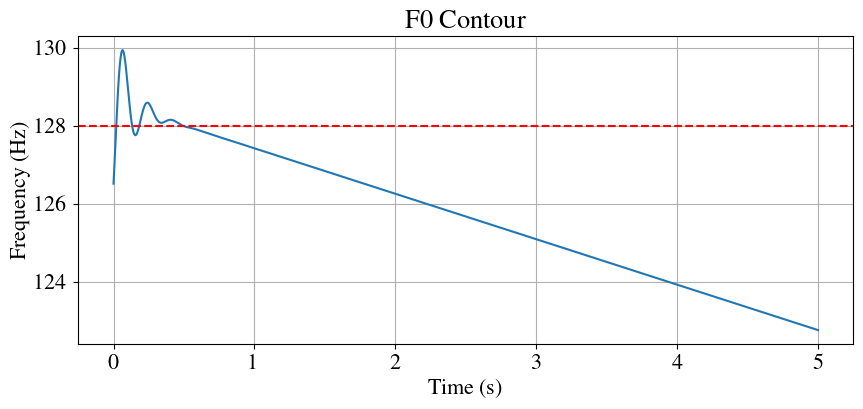

In [30]:
buffer_size = 512; Fs = 22500
length = Fs/buffer_size # length in frames (here set to be 1 second)

Ts = 1/Fs
alpha = 0.13  # Arbitrary chosen
beta = 0.6  # Arbitrary chosen
gamma = 12 * 2 * np.pi / 25  # 4 full sine wave cycle every 25 frames
theta = 5
phi = 0.02

print("f0:", F0)
# Define the function for the F0 contour
def F0_contour(x, F0, alpha, beta, gamma, theta):
    x = x*buffer_size/length # use with the time setting only

    contour = F0 * (1 - alpha * x) * np.exp(-beta * x) * np.sin(gamma * x - 0.3*np.pi) - theta*x + F0
    contour = (contour - contour[int(0.5*FS)]) * phi + F0

    return contour

# Generate x values corresponding to frame numbers
time = np.arange(0, 5*length*buffer_size*Ts, Ts)

# Calculate the F0 contour  
contour = F0_contour(time, F0, alpha, beta, gamma, theta)

# extend the f0 contour with the last frequency value
#contour = np.concatenate([np.full(int(0.2 * Fs), contour[0]), contour])

# add a vibrato effect
vibrato = 3 # Hz
t = np.arange(0, len(contour)/Fs, 1/Fs)
#modulation = 0.3 * np.sin(2 * np.pi * vibrato * t) # * 1/(1+np.exp(-5*t+5))
#contour = contour + modulation

plt.figure(figsize=(10, 4))
plt.plot(t, contour)
plt.title('F0 Contour')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.grid(True)
plt.axhline(F0, color='r', linestyle='--')
#plt.twinx()
#plt.plot(t, , color= 'r')
plt.show()

In [31]:
from voicerUtils import *

""" fs, datain = wavfile.read(IN_AUDIO_FILE)
if(len(datain.shape) > 1):
    datain = datain[:, 0] # remove right channel if stereo

# trim data 
#datain = datain[int(0.15*fs):int(1.0*fs)]
datain = librosa.resample(datain.astype(np.float32), orig_sr=fs, target_sr=FS) """

datain = audio_data_

Audio(datain, rate=FS)

In [37]:
from voicerUtils import v_glotlf

N = 1024; N2 = N // 2; INT16_MAX = 32767

# hanning sine window for each frame
#sinW = signal.windows.hann(N)
# since we're using odft the window should be shifted
sinW = np.sin(np.pi * (np.arange(0, N) + 0.5) / N)

# input and output buffers
old_inBuff  = np.zeros(N2)
old_outBuff = np.zeros(N2)

# pulse buffers
pulseBuffer = np.zeros(N) # 1024 samples long
# initialization for the first the pulse, such that the alpha coefficient for the PSD calculation is never 0
lastPulsePos = 1 

# power spectral density
old_psd = np.zeros(N)
pulse_psd = np.zeros(N)

# output file
outputFile = np.array([])
# tilt compensation factor
tilt = tiltGain(F0, FS, N)
tilt = np.concatenate((tilt, tilt[::-1]))

aaa = np.array([])

currF0 = 0
f0contour = np.concatenate((contour, np.full(10*FS, contour[-1])))

#CoG = np.array([])

noiseTemplate = np.random.normal(0, 0.1, N)

#plt.plot(f0contour)

Fvuv = 1800; Fuv = 2400

# load new frames 512 samples at a time
for start in range(0, len(datain) - N2, N2):
    in_frame = datain[start : start + N2]

    if(len(in_frame) != N2):
        in_frame = np.pad(in_frame, (0, N2 - len(in_frame)), 'constant')

    # Concatenate input sequence and apply window
    winFrame = np.concatenate((old_inBuff, in_frame)) * sinW
    old_inBuff = in_frame

    # DFT and compute PSD for current frame
    curr_spectrum = odft(winFrame, N)
    curr_psd = np.abs(curr_spectrum) ** 2

    # pulse generation
    pulseBuffer[:N2] = pulseBuffer[N2:] # shift the buffer
    pulseBuffer[N2:] = 0 # clear the second half of the buffer

    # compute centre of gravity and energy from PSD
    cog = np.sum(curr_psd[:N2] * (np.arange(0, N2)*FS)/N) / np.sum(curr_psd[:N2])
    energy = np.sum(curr_psd[:N2])
    
    #CoG = np.concatenate((CoG, np.array([cog])))
    unvoiced = m(cog, Fvuv, Fuv)
    activity = WAD(in_frame) # here we need the in_frame such that we can compute the zero crossing rate
    
    aaa = np.concatenate((aaa, np.array([unvoiced])))

    while lastPulsePos < N2:
        """ if(lastPulsePos == 0): # as to avoid Nan in pulse_psd calculation
            lastPulsePos += 1 """

        # generate both a pulse and noise
        f0 = f0contour[currF0]
        pLen = int(FS/f0)
        t = np.arange(0, 1/f0, 1/FS)
        idx = np.arange(currF0, currF0 + len(t))
        pulse = v_glotlf(1, t*f0contour[idx])
        #pulse = singleLFpulse(F0, FS, tmpmag, nrd_approx)
        #noise = np.random.normal(0, 0.1, len(pulse)) * 0.2
        noise = noiseTemplate[:len(pulse)] * 0.2

        # psd mixing coefficient
        alpha = lastPulsePos / N2
        #pulse_psd = curr_psd
        pulse_psd = (alpha)*curr_psd + (1-alpha)*old_psd # average the psds

        # TODO: add noise and tilt compensation to the psd right here
        pulse_psd = pulse_psd / tilt
        
        uvmix = unvoiced * 0.5 + 0.5
        pulse = (pulse * (1-uvmix) + noise*uvmix) * activity # add noise if unvoiced
        #pulse = noise # synthetic whisper mode
        
        r = iodft(pulse_psd, N).real # weiner-khinchin
        [a, e, k] = levinson(r, 22)
        b0 = np.sqrt(e)

        lastPulseLen = len(//! AINDA NÃO VERIFIQUEI ESTA MERDApulse)
        pulse = np.concatenate((pulse, np.zeros(300)))

        # filter the pulse
        filteredPulse = signal.lfilter(b0, a, pulse)
        pulseBuffer[lastPulsePos : lastPulsePos + len(filteredPulse)] += filteredPulse

        # update pulse position
        lastPulsePos += lastPulseLen
        currF0 += pLen # update curr frequency

    if(unvoiced > 0.5 or activity < 0.5): # Reset frequency contour if unvoiced
        currF0 = 0

    lastPulsePos -= N2
    output = pulseBuffer[:N2] # first half of the buffer
    old_psd = curr_psd

    # Add the output through overlap add and save the previous output
    #outputFile = np.concatenate((outputFile, (old_outBuff * sinW[:N2] + output * sinW[N2:])))
    outputFile = np.concatenate((outputFile, output))
    #outputFileAlt= np.concatenate((outputFile, output))
    old_outBuff = output

outputFile = outputFile / max(abs(outputFile)) * INT16_MAX
#outputFileAlt = outputFileAlt / max(abs(outputFileAlt)) * INT16_MAX # this is the same

# write to the output file
wavfile.write(OUTPUT_FILE, FS, outputFile.astype(np.int16))

Audio(OUTPUT_FILE, rate=FS)

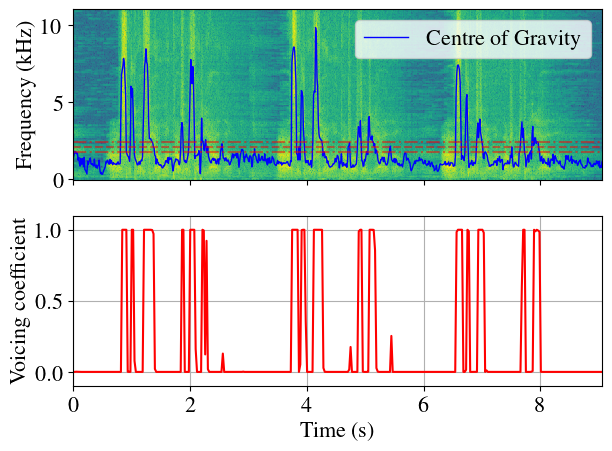

/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/data/output.wav


In [33]:
fig, axs = plt.subplots(2, 1, sharex=True)

# First subplot
axs[0].pcolormesh(times, frequencies/1e3, 10 * np.log10(psd))
axs[0].plot(np.linspace(0, times[-1], len(CoG)), CoG/1e3, color='b', linewidth=1, label="Centre of Gravity")
axs[0].set_ylabel('Frequency (kHz)')
axs[0].legend()
axs[0].axhline(np.sqrt(Fvuv*Fuv)/1e3, color='r', linestyle='--', alpha = 0.5)
axs[0].axhline(Fvuv/1e3, color='r', linestyle='-.', alpha = 0.5)
axs[0].axhline(Fuv/1e3, color='r', linestyle='-.', alpha = 0.5)

# Second subplot
axs[1].plot(np.linspace(0, len(outputFile)/FS, len(aaa)), aaa, color='r')
#axs[1].plot(np.linspace(0, len(outputFile)/FS, len(activity)), activity, color='b')
axs[1].set_ylim((-0.1, 1.1))
axs[1].set_ylabel('Voicing coefficient')
axs[1].set_xlabel('Time (s)')
axs[1].grid(True)

axs[0].set_xlim(0, times[-1])
axs[1].set_xlim(0, times[-1])

plt.tight_layout()
plt.show()

print(OUTPUT_FILE)

### TODO:

- Validate the segmentation algorithm on STM32
- Determine a good set of parameters for the mapping function (ask for data set and train these heuristics)
- Get the voicing algorithm to follow an $F_0$ contour, so whenever determine when new $F_0$ curves are necessary
- Work on MUSHRA, get other results do we can compare them
- Figure out the noise issue with the stm32...

- Concatenate the vowels

| Subject | Phrase | $F_{VUV}$ | $F_{UV}$ |
|---------|--------|---------|--------|
| SPF05 | Aviao | 2400 | 3400 |
| SPF12 | Tiago | 2400 | 3400 |
| SPM14 | Tiago | 1800 | 2400 |
| SPM18 | Aviao | 1800 | 2400 |